# Imports

In [ ]:
%%capture
!pip install albumentations

In [ ]:
%%capture
!pip install -U segmentation-models-pytorch

In [ ]:
%%capture
!pip install kaggle

In [ ]:
%%capture
!pip install datasets

In [ ]:
%%capture
!pip install monai

In [ ]:
# Downloading dataset from kaggle
#upload kaggle.json
from google.colab import files
#uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p /content
!unzip /content/lgg-mri-segmentation.zip -d /content/dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  

In [ ]:
import random
import os
import glob
import time
import warnings
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
# import opendatasets as od
import datasets as dts

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from statistics import mean


import torch
import monai
import cv2
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from monai.transforms import Compose, NormalizeIntensityd
from monai.metrics import compute_iou
from sklearn.model_selection import train_test_split

from transformers import SamProcessor
from transformers import SamModel

# CONFIGURATION

In [ ]:
plt.style.use("dark_background")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [ ]:
import glob
class CFG:
    DATASET_PATH = "/content/dataset/lgg-mri-segmentation/"
    TRAIN_PATH = "/content/dataset/lgg-mri-segmentation/kaggle_3m/"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TRAIN_BATCH_SIZE = 2
    TEST_BATCH_SIZE = 1
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 0
    EPOCH = 5

# DATA PREPARATION

In [ ]:
dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")
dataset_images[:5]

['/content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_16.tif',
 '/content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_4_mask.tif',
 '/content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_19_mask.tif',
 '/content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_6.tif',
 '/content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_20.tif']

In [ ]:
def get_sample_patient_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]

def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []

    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        if 'mask.tif' in path_list:
            sample_numbers.append(int(path_list[-2]))
            is_mask.append(1)
        else:
            sample_numbers.append(int(path_list[-1].replace('.tif', '')))
            is_mask.append(0)

    return sample_numbers, is_mask

def build_df(image_paths):
    sample_numbers, mask_label = get_sample_number(image_paths)
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'patient'   : get_sample_patient_id(image_paths),
        'image_path': image_paths,
        'is_mask'   : mask_label
    })

    return df

In [ ]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'patient', 'image_path'])
    .reset_index(drop=True)
)

dataset_df

,id,patient,image_path,is_mask
0,1,TCGA_CS_4941_19960909,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
1,1,TCGA_CS_4941_19960909,/content/dataset/lgg-mri-segmentation/kaggle_3...,1
2,1,TCGA_CS_4942_19970222,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
3,1,TCGA_CS_4942_19970222,/content/dataset/lgg-mri-segmentation/kaggle_3...,1
4,1,TCGA_CS_4943_20000902,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
...,...,...,...,...
7853,87,TCGA_HT_A61B_19991127,/content/dataset/lgg-mri-segmentation/kaggle_3...,1
7854,88,TCGA_HT_A61A_20000127,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
7855,88,TCGA_HT_A61A_20000127,/content/dataset/lgg-mri-segmentation/kaggle_3...,1
7856,88,TCGA_HT_A61B_19991127,/content/dataset/lgg-mri-segmentation/kaggle_3...,0


In [ ]:
grouped_df = dataset_df.groupby(by='is_mask')
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True),
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

mask_df.head()

,id,patient,mask_path
0,1,TCGA_CS_4941_19960909,/content/dataset/lgg-mri-segmentation/kaggle_3...
1,1,TCGA_CS_4942_19970222,/content/dataset/lgg-mri-segmentation/kaggle_3...
2,1,TCGA_CS_4943_20000902,/content/dataset/lgg-mri-segmentation/kaggle_3...
3,1,TCGA_CS_4944_20010208,/content/dataset/lgg-mri-segmentation/kaggle_3...
4,1,TCGA_CS_5393_19990606,/content/dataset/lgg-mri-segmentation/kaggle_3...


In [ ]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.

def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1
    return 0

In [ ]:
ds = images_df.merge(
    mask_df,
    on=['id', 'patient'],
    how='left'
)

ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]
ds.head()

  0%|          | 0/3929 [00:00<?, ?it/s]

,id,patient,image_path,mask_path,diagnosis
0,1,TCGA_CS_4941_19960909,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
1,1,TCGA_CS_4942_19970222,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
2,1,TCGA_CS_4943_20000902,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
3,1,TCGA_CS_4944_20010208,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...,0
4,1,TCGA_CS_5393_19990606,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...,0


In [ ]:
ds = ds[ds['diagnosis']==1]
ds = ds.head(1360)

In [ ]:
image_train, image_test, mask_train, mask_test = train_test_split(
ds['image_path'], ds['mask_path'], test_size = 0.10)

In [ ]:
train_df = pd.concat([image_train, mask_train], axis=1).reset_index(drop=True)
train_dataset = dts.Dataset.from_pandas(train_df)

In [ ]:
test_df = pd.concat([image_test, mask_test], axis=1).reset_index(drop=True)
test_dataset = dts.Dataset.from_pandas(test_df)

In [ ]:
def transform(data):
    with open(data['image_path'], 'rb') as f:
        image = Image.open(io.BytesIO(f.read())).convert('RGB')
    data['image'] = image

    with open(data['mask_path'], 'rb') as f:
        mask = Image.open(io.BytesIO(f.read())).convert('L')
    data['mask'] = mask

    return data

In [ ]:
train_dataset = train_dataset.map(transform, remove_columns=['image_path','mask_path'])

Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 1224
})

In [ ]:
test_dataset = test_dataset.map(transform, remove_columns=['image_path','mask_path'])

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

In [ ]:
test_dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 136
})

In [ ]:
example = train_dataset[0]
img = example['image']
msk = example['mask']

In [ ]:
np.array(msk).max(), np.array(msk).min(), np.array(img).max(), np.array(img).min()

(255, 0, 235, 0)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

(-0.5, 255.5, 255.5, -0.5)

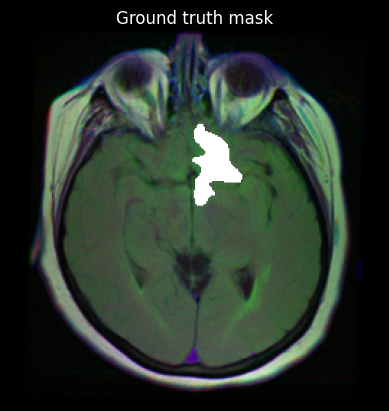

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(img))
ground_truth_seg = np.array(example["mask"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [ ]:
def get_bounding_box(ground_truth_map):
    if len(np.unique(ground_truth_map)) > 1:

        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256]

In [ ]:
class SAMDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["ground_truth_mask"] = ground_truth_mask/255

    return inputs

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base", do_normalize=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_sam_ds = SAMDataset(dataset=train_dataset, processor=processor)

In [ ]:
exmpl = train_sam_ds[10]
for k,v in exmpl.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
train_dataloader = DataLoader(train_sam_ds, batch_size=CFG.TRAIN_BATCH_SIZE, shuffle=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
train_df.shape

(1224, 2)

## Compare Results of SAM and SAM+FeatUp

**Compare Results of SAM and SAM+FeatUp**

The OutOfMemoryError indicates that the GPU ran out of memory during the inference process, likely because the FeatUp model increases the size of the input images, leading to higher memory usage.

To mitigate this issue, you can reduce the batch size, use gradient accumulation, or perform inference in smaller chunks. Here's how you can reduce the batch size and add an option to clear the CUDA cache to free up memory during inference:

Reduce the batch size: This will reduce the memory requirement per batch.
Clear CUDA cache: Clearing the cache after processing each batch can help free up memory.
Here's how you can update the code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SamModel.from_pretrained("facebook/sam-vit-base")
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

state_dict = torch.load('/content/drive/MyDrive/SkoltechDL24/sam_featup_epoch_4.pth')

model.load_state_dict(state_dict)

model.to(device)

seg_loss = monai.losses.FocalLoss(reduction='mean')

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
use_norm = True
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16', use_norm=use_norm).to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mhamilton723/FeatUp/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/din

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
  transforms.Resize((64,64)),
])
transform2 = transforms.Compose([
  transforms.Resize((1024,1024)),
])

In [ ]:
import os
import json
import torch
import numpy as np
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.losses import FocalLoss
from monai.transforms import AsDiscrete, Activations
from torch.optim import Adam
import matplotlib.pyplot as plt

# Initialize the Dice metric
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Define custom metric functions
def compute_accuracy(y_pred, y_true):
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

def compute_precision(y_pred, y_true):
    tp = (y_pred * y_true).sum().float()
    fp = (y_pred * (1 - y_true)).sum().float()
    precision = tp / (tp + fp + 1e-8)
    return precision.item()

def compute_recall(y_pred, y_true):
    tp = (y_pred * y_true).sum().float()
    fn = ((1 - y_pred) * y_true).sum().float()
    recall = tp / (tp + fn + 1e-8)
    return recall.item()

def compute_f1(y_pred, y_true):
    precision = compute_precision(y_pred, y_true)
    recall = compute_recall(y_pred, y_true)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as T
from PIL import Image
from featup.util import pca

# Keep the original image size
original_image_size = (1024, 1024)
image_size = (32, 32)  # Reduced image size for intermediate processing

# Define the function to compute the Intersection over Union (IoU)
def compute_iou(pred_mask, true_mask, ignore_empty=False):
    intersection = torch.logical_and(pred_mask, true_mask).float().sum((1, 2))
    union = torch.logical_or(pred_mask, true_mask).float().sum((1, 2))
    iou = intersection / union
    if ignore_empty:
        return iou
    return torch.where(union > 0, iou, torch.tensor(1.0))

# Inference with SAM Model
def inference_with_sam(model, test_dataloader):
    model.eval()
    test_ious = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []
    test_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

            sam_masks_prob = torch.sigmoid(predicted_masks)
            sam_masks_prob = sam_masks_prob.squeeze()
            sam_masks = (sam_masks_prob > 0.5)

            loss = seg_loss(predicted_masks, ground_truth_masks)
            test_losses.append(loss.item())
            ious = compute_iou(sam_masks.unsqueeze(1), ground_truth_masks, ignore_empty=False)
            test_ious.append(ious.mean().item())

            # Post-processing
            outputs = Activations(sigmoid=True)(predicted_masks)
            outputs = AsDiscrete(threshold=0.5)(outputs)

            # Update metrics
            dice_metric(y_pred=outputs, y=ground_truth_masks)

            # Compute other metrics
            accuracy = compute_accuracy(outputs, ground_truth_masks)
            precision = compute_precision(outputs, ground_truth_masks)
            recall = compute_recall(outputs, ground_truth_masks)
            f1 = compute_f1(outputs, ground_truth_masks)
            dice_score = dice_metric.aggregate().item()

            test_accuracies.append(accuracy)
            test_precisions.append(precision)
            test_recalls.append(recall)
            test_f1s.append(f1)
            test_dice_scores.append(dice_score)

            torch.cuda.empty_cache()  # Clear CUDA cache to free up memory
    return test_ious, test_losses, test_accuracies, test_precisions, test_recalls, test_f1s, test_dice_scores

# Inference with SAM+FeatUp Model
def inference_with_sam_featup(model, upsampler, test_dataloader):
    model.eval()
    test_ious = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []
    test_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            # Upsample input images using FeatUp
            images = transform(batch["pixel_values"]).to(device)
            hr_feats = upsampler(images)
            lr_feats = upsampler.model(images)

            # Unnormalize and apply PCA
            lr, hr = lr_feats[0], hr_feats[0]
            [lr_feats_pca, hr_feats_pca], _ = pca([lr.unsqueeze(0), hr.unsqueeze(0)])
            enhanced_images = hr_feats_pca[0].unsqueeze(0)

            outputs = model(pixel_values=transform2(enhanced_images),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

            sam_masks_prob = torch.sigmoid(predicted_masks)
            sam_masks_prob = sam_masks_prob.squeeze()
            sam_masks = (sam_masks_prob > 0.5)

            loss = seg_loss(predicted_masks, ground_truth_masks)
            test_losses.append(loss.item())
            ious = compute_iou(sam_masks.unsqueeze(1), ground_truth_masks, ignore_empty=False)
            test_ious.append(ious.mean().item())

            # Post-processing
            outputs = Activations(sigmoid=True)(predicted_masks)
            outputs = AsDiscrete(threshold=0.5)(outputs)

            # Update metrics
            dice_metric(y_pred=outputs, y=ground_truth_masks)

            # Compute other metrics
            accuracy = compute_accuracy(outputs, ground_truth_masks)
            precision = compute_precision(outputs, ground_truth_masks)
            recall = compute_recall(outputs, ground_truth_masks)
            f1 = compute_f1(outputs, ground_truth_masks)
            dice_score = dice_metric.aggregate().item()

            test_accuracies.append(accuracy)
            test_precisions.append(precision)
            test_recalls.append(recall)
            test_f1s.append(f1)
            test_dice_scores.append(dice_score)

            torch.cuda.empty_cache()  # Clear CUDA cache to free up memory
    return test_ious, test_losses, test_accuracies, test_precisions, test_recalls, test_f1s, test_dice_scores

# Create a smaller test dataset for demonstration purposes
class SmallerSAMDataset(SAMDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transforms = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Resize(original_image_size)  # Resize back to original size
        ])

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        pixel_values = np.array(item['pixel_values'])

        # Debugging statements
        #print(f"Original pixel_values shape: {pixel_values.shape}, dtype: {pixel_values.dtype}")

        pixel_values = pixel_values.astype(np.uint8)  # Ensure the image is an ndarray with uint8 type
        pixel_values = pixel_values.squeeze()  # Remove any singleton dimensions

        # Debugging statements
        #print(f"After squeeze pixel_values shape: {pixel_values.shape}, dtype: {pixel_values.dtype}")

        if pixel_values.ndim == 3 and pixel_values.shape[0] == 3:  # If the image is in CHW format, convert to HWC
            pixel_values = np.transpose(pixel_values, (1, 2, 0))

        # Debugging statements
        #print(f"After transpose pixel_values shape: {pixel_values.shape}, dtype: {pixel_values.dtype}")

        pixel_values = Image.fromarray(pixel_values)  # Convert ndarray to PIL image

        # Debugging statements
        #print(f"Converted to PIL image: size: {pixel_values.size}, mode: {pixel_values.mode}")

        pixel_values = self.transforms(pixel_values)  # Apply transformations
        item['pixel_values'] = pixel_values
        return item

In [ ]:
# Create test dataloader with smaller batch size
test_sam_ds = SmallerSAMDataset(test_dataset, processor=processor)
test_dataloader = DataLoader(test_sam_ds, batch_size=1, shuffle=False)

In [ ]:
# Perform inference with SAM model
sam_metrics = inference_with_sam(model, test_dataloader)

100%|██████████| 136/136 [01:18<00:00,  1.72it/s]


In [ ]:
# Perform inference with SAM+FeatUp model
sam_featup_metrics = inference_with_sam_featup(model, upsampler, test_dataloader)

  0%|          | 0/136 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 136/136 [01:31<00:00,  1.49it/s]


In [ ]:
print("IoUs: ", np.mean(sam_metrics[0]), np.mean(sam_featup_metrics[0]))
print("Losses: ", np.mean(sam_metrics[1]), np.mean(sam_featup_metrics[1]))
print("Accuracies: ", np.mean(sam_metrics[2]), np.mean(sam_featup_metrics[2]))
print("Precisions: ", np.mean(sam_metrics[3]), np.mean(sam_featup_metrics[3]))
print("Recalls: ", np.mean(sam_metrics[4]), np.mean(sam_featup_metrics[4]))
print("F1s: ", np.mean(sam_metrics[5]), np.mean(sam_featup_metrics[5]))
print("Dice scores: ", np.mean(sam_metrics[6]), np.mean(sam_featup_metrics[6]))

IoUs:  0.8094577403629527 0.8101327651563812
Losses:  0.04417805236110272 0.01599253414058373
Accuracies:  0.9721265680649701 0.9762700024773093
Precisions:  0.508882497492082 0.5728663968826261
Recalls:  0.28569288683844635 0.42583809186843985
F1s:  0.2947038325386279 0.4351097761851779
Dice scores:  0.2870401260169113 0.33951521182761474


Mean IoU for SAM model: 0.8287108308252167
Mean IoU for SAM+FeatUp model: 0.8535676861510557


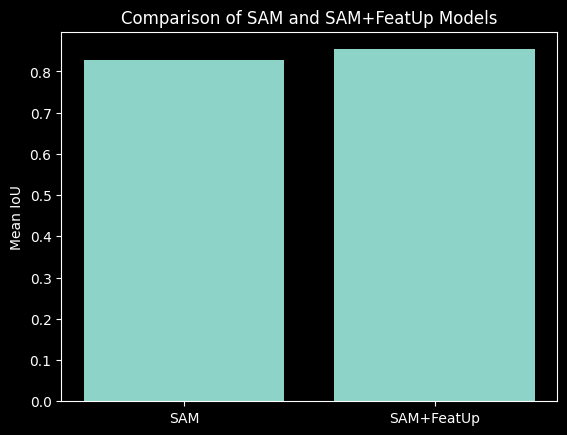

In [ ]:
# Compare Results
mean_sam_iou = np.mean(sam_ious)
mean_sam_featup_iou = np.mean(sam_featup_ious)

print(f'Mean IoU for SAM model: {mean_sam_iou}')
print(f'Mean IoU for SAM+FeatUp model: {mean_sam_featup_iou}')

# Plot Comparison
plt.figure()
plt.bar(['SAM', 'SAM+FeatUp'], [mean_sam_iou, mean_sam_featup_iou])
plt.ylabel('Mean IoU')
plt.title('Comparison of SAM and SAM+FeatUp Models')
plt.show()